# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. <br>
**Analysis :**

1. There are in total 663 videos each containing 30 frames in train folder and 100 videos with 30 frames for validation.

2. Some of the videos have the dimensions 120 X 160 , whereas some are 360 X 360

3. The folder name and corresponding gesture label is stored in train.csv and val.csv files.
4. There are total 5 gestures viz. thumbs up , thumbs down , left swipe , right swipe , stop.

4. For image preprocessing , we will be doing resizing , cropping , normalization , affine transformation , image sharpening , image segmentation. <br><br>

For this assignment , we used google colab  since it provides 25gb of GPU which helps in faster processing.
For this , we had to upload the zipped data folder to google drive and then copy it to colab sesson and then unzip it. 
Note :: For running it locally , we need to change the folder path accordingly.

Since 27th March , 2020 colab has by default upgraded to tensorflow 2.X due to which we had to change the random_seed() and the imports now start with "tensorflow.python." prefix. For running it on tensowflow < 2.X we need to revert this changes.

**Group Project Members :**
1. Ajit Nalawade
2. Gaurav Desurkar




In [0]:
import numpy as np
import os
import datetime
import os 
import matplotlib.pyplot as plt
import cv2
from scipy import ndimage

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf

#using tensor flow 2.x
tf.random.set_seed(30)

#Using tensorflow < 2.0
#tf.set_random_seed(30)

Using TensorFlow backend.


**Upload the zipped file in google drive in "notebooks" folder.**
comment the below two blocks if running on local machine. 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
#Copy the uploaded zip file in google drive to colab session for faster processing.
!cp -r '/content/drive/My Drive/notebooks/Project_data.zip' '/'

#Unzip the data in  colab session for faster processing.
!unzip '/Project_data.zip' -d '/notebooks/'


Streaming output truncated to the last 5000 lines.
 extracting: /notebooks/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00052.png  
 extracting: /notebooks/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00054.png  
 extracting: /notebooks/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00056.png  
 extracting: /notebooks/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00058.png  
 extracting: /notebooks/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00060.png  
 extracting: /notebooks/Project_data/train/WIN_20180926_17_34_37_Pro_Stop_new/WIN_20180926_17_34_37_Pro_00062.png  
   creating: /notebooks/Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/
 extracting: /notebooks/Project_data/train/WIN_20180926_17_35_12_Pro_Thumbs_Down_new/WIN_20180926_17_35_12_Pro_00001.png  
 extracting: /notebooks/Project_data/train/W

# **Preprocess the images**


In [0]:
# Display five  images
def display(a, b, c ,d ,e , title1 = "Original", title2 = "Edited"):
  plt.subplot(151), plt.imshow(a), plt.title(title1)
  plt.xticks([]), plt.yticks([])
  plt.subplot(152), plt.imshow(b), plt.title(title2)
  plt.xticks([]), plt.yticks([])
  plt.subplot(153), plt.imshow(c), plt.title(title2)
  plt.xticks([]), plt.yticks([])
  plt.subplot(154), plt.imshow(d), plt.title(title2)
  plt.xticks([]), plt.yticks([])
  plt.subplot(155), plt.imshow(e), plt.title(title2)
  plt.xticks([]), plt.yticks([])
  plt.show()

def resize_image(org_image,x,y):
  resized_image = cv2.resize(org_image, (x,y), interpolation=cv2.INTER_LINEAR)
  return resized_image
  
def getRandomAffine():
  dx, dy = np.random.randint(-1.7, 1.8, 2)
  return np.float32([[1, 0, dx], [0, 1, dy]])

def affineTransformation(image,M):
  return cv2.warpAffine(image, M, (image.shape[0], image.shape[1]))

def imageSharpening(image):
  rgbArray = np.zeros((image.shape[0],image.shape[1],3), 'uint8')

  blurred_f = ndimage.gaussian_filter(image[:, : , 0], 1)
  filter_blurred_f = ndimage.gaussian_filter(blurred_f, 1)
  alpha = 20
  sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)

  rgbArray[:,:,0] = sharpened

  blurred_f = ndimage.gaussian_filter(image[:, : , 1], 1)
  filter_blurred_f = ndimage.gaussian_filter(blurred_f, 1)
  alpha = 10
  sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)

  rgbArray[:,:,1] = sharpened

  blurred_f = ndimage.gaussian_filter(image[:, : , 2], 1)
  filter_blurred_f = ndimage.gaussian_filter(blurred_f, 1)
  alpha = 10
  sharpened = blurred_f + alpha * (blurred_f - filter_blurred_f)

  rgbArray[:,:,2] = sharpened
  return rgbArray

def imageSegmentation(image):  
  blur1 = cv2.GaussianBlur(image, (3,3), 0)
  gray = cv2.cvtColor(blur1, cv2.COLOR_RGB2GRAY)
  ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
  backtorgb = cv2.cvtColor(thresh,cv2.COLOR_GRAY2RGB)
  return backtorgb

**Affine Transformation** <br>
About affine transformation <br>
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html

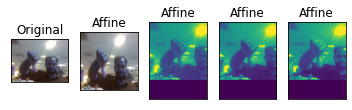

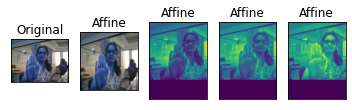

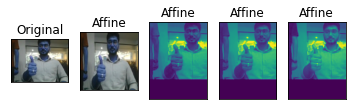

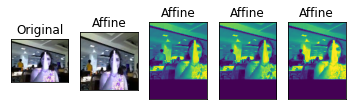

In [4]:
original_image = [ '/notebooks/Project_data/val/WIN_20180926_17_44_14_Pro_Thumbs_Down_new/WIN_20180926_17_44_14_Pro_00031.png' ,        
                  '/notebooks/Project_data/train/WIN_20180926_17_37_02_Pro_Stop_new/WIN_20180926_17_37_02_Pro_00051.png',            
                  '/notebooks/Project_data/train/WIN_20180926_17_39_25_Pro_Thumbs_Up_new/WIN_20180926_17_39_25_Pro_00043.png',
                  '/notebooks/Project_data/train/WIN_20180926_17_36_34_Pro_Right_Swipe_new/WIN_20180926_17_36_34_Pro_00057.png',                             
                  ]

for i in range(len(original_image)):
  org_image = cv2.imread(original_image[i])
  resized_image = resize_image(org_image , 120,120)
  M = getRandomAffine()
  transformed_image = affineTransformation(org_image,M)
  display(org_image, resized_image , transformed_image[:,:,0] , transformed_image[:,:,1] , transformed_image[:,:,2], 'Original', 'Affine')

**Image Sharpening** <br>
About image sharpening <br>
http://scipy-lectures.org/advanced/image_processing/auto_examples/plot_sharpen.html 

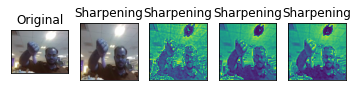

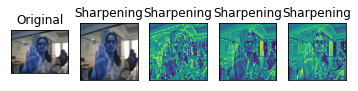

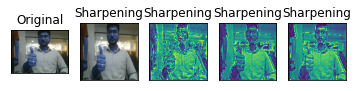

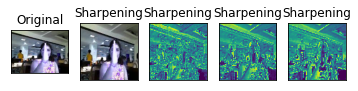

In [5]:
original_image = [ '/notebooks/Project_data/val/WIN_20180926_17_44_14_Pro_Thumbs_Down_new/WIN_20180926_17_44_14_Pro_00031.png' ,        
                  '/notebooks/Project_data/train/WIN_20180926_17_37_02_Pro_Stop_new/WIN_20180926_17_37_02_Pro_00051.png',            
                  '/notebooks/Project_data/train/WIN_20180926_17_39_25_Pro_Thumbs_Up_new/WIN_20180926_17_39_25_Pro_00043.png',
                  '/notebooks/Project_data/train/WIN_20180926_17_36_34_Pro_Right_Swipe_new/WIN_20180926_17_36_34_Pro_00057.png',                             
                  ]

for i in range(len(original_image)):
  org_image = cv2.imread(original_image[i])
  resized_image = resize_image(org_image , 120,120)
  transformed_image = imageSharpening(resized_image)
  display(org_image, resized_image , transformed_image[:,:,0] , transformed_image[:,:,1] , transformed_image[:,:,2], 'Original', 'Sharpening')

**Image Segmentation** <br>
About Image segmentation <br>
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html

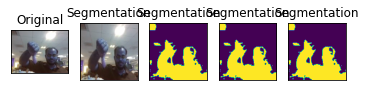

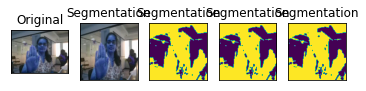

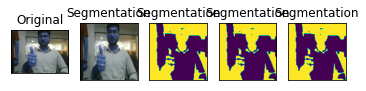

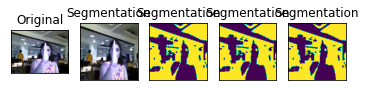

In [6]:
original_image = [ '/notebooks/Project_data/val/WIN_20180926_17_44_14_Pro_Thumbs_Down_new/WIN_20180926_17_44_14_Pro_00031.png' ,        
                  '/notebooks/Project_data/train/WIN_20180926_17_37_02_Pro_Stop_new/WIN_20180926_17_37_02_Pro_00051.png',            
                  '/notebooks/Project_data/train/WIN_20180926_17_39_25_Pro_Thumbs_Up_new/WIN_20180926_17_39_25_Pro_00043.png',
                  '/notebooks/Project_data/train/WIN_20180926_17_36_34_Pro_Right_Swipe_new/WIN_20180926_17_36_34_Pro_00057.png',                             
                  ]

for i in range(len(original_image)):
  org_image = cv2.imread(original_image[i])
  resized_image = resize_image(org_image , 120,120)
  transformed_image = imageSegmentation(resized_image)

  display(org_image, resized_image , transformed_image[:,:,0] , transformed_image[:,:,1] , transformed_image[:,:,2], 'Original', 'Segmentation')

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [0]:
img_idx = range(0,30)
x = 30   # No of images in each folder to use 
y = 120  # height of the image
z = 120  # Width of the image

def generator(source_path, folder_list, batch_size , imageprocessing , normalize = True , crop=False):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size;
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                #for affine transforamtion
                M = getRandomAffine()

                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item])
                   
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resize_image = cv2.resize(image, (y,z), interpolation=cv2.INTER_LINEAR)
                    
                 
                    if normalize:
                        # normalization
                        resize_image = resize_image / 255

                    if crop:
                        resize_image =   resize_image[30:120 , 0: 110]                        
                    
                    if imageprocessing == 'affine':                        
                        transformed_image = affineTransformation(resize_image,M)
                    elif imageprocessing == 'sharpen':
                        transformed_image = imageSharpening(resize_image)
                    elif imageprocessing == 'segment':
                        transformed_image = imageSegmentation(resize_image)   
                    else:
                        transformed_image =resize_image
                   
                    batch_data[folder,idx,:,:,0] = transformed_image[:,:,0]
                    batch_data[folder,idx,:,:,1] = transformed_image[:,:,1]
                    batch_data[folder,idx,:,:,2] = transformed_image[:,:,2]
                                                           
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        #Check if there are any remaining folders to be processed
        if len(t) % batch_size != 0 :                  
            start = (batch_size*num_batches)
            end = len(t)
            batch_data = np.zeros((end-start,x,y,z,3))
            batch_labels = np.zeros((end-start,5))
            for index,folder in enumerate(range(start , end)): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder].split(';')[0]) # read all the images in the folder
                dx, dy = np.random.randint(-1.7, 1.8, 2)
                M = np.float32([[1, 0, dx], [0, 1, dy]])
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                  
                    image = cv2.imread(source_path+'/'+ t[folder].strip().split(';')[0]+'/'+imgs[item])

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    resize_image = cv2.resize(image, (y,z), interpolation=cv2.INTER_LINEAR)

                    if normalize:
                        # normalization
                        resize_image = resize_image / 255

                    if crop:
                        resize_image =   resize_image[30:120 , 0: 110]                        

                    if imageprocessing == 'affine':                        
                        transformed_image = affineTransformation(resize_image,M)
                    elif imageprocessing == 'sharpen':
                        transformed_image = imageSharpening(resize_image)
                    elif imageprocessing == 'segment':
                        transformed_image = imageSegmentation(resize_image)   
                    else:
                        transformed_image =resize_image
                        
                    batch_data[index,idx,:,:,0] = transformed_image[:,:,0]
                    batch_data[index,idx,:,:,1] = transformed_image[:,:,1]
                    batch_data[index,idx,:,:,2] = transformed_image[:,:,2]

                batch_labels[index, int(t[folder].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do        

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [0]:
# Since March 27 ,2020 , Colab has been switched to tensorflow 2.x by default . Hence, to run the code on colab we need to import using "tensorflow.python." package prefix.
#If running on tensorflow < 2.0 , remove the prefix "tensorflow.python." from each of the below imports.

from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense, Input , Flatten , Dropout ,BatchNormalization , GRU , Activation
#from keras.layers import Dense, GRU , LSTM , Flatten, TimeDistributed, Flatten, BatchNormalization, Activation , Dropout , Input , GlobalAveragePooling2D , Reshape
from tensorflow.python.keras.layers.convolutional import Conv3D, MaxPooling3D , MaxPooling2D , Conv2D 
from tensorflow.python.keras.layers.pooling import GlobalAveragePooling2D
from tensorflow.python.keras.layers.recurrent import LSTM
from tensorflow.python.keras.layers.wrappers import TimeDistributed
from tensorflow.python.keras.optimizers import Nadam
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [0]:
#Helper method to compile and execute the model
def compile_and_execute_model(model, imageprocessing , normalize = True, crop= False ,batch_size = 15 , num_epochs = 40 , optimizer="Adam" , lr_factor=0.4):

  #COMPILE THE MODEL
  #https://keras.io/optimizers/
  #optimiser = Adam()
  #optimiser = optimizers.SGD(lr=0.001, nesterov=True)
  
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
  print (model.summary()) 


  #CREATE TRAIN AND VALIDATION REFERENCE
  train_doc = np.random.permutation(open('/notebooks/Project_data/train.csv').readlines())
  val_doc = np.random.permutation(open('/notebooks/Project_data/val.csv').readlines())

  curr_dt_time = datetime.datetime.now()
  train_path = '/notebooks/Project_data/train'
  val_path = '/notebooks/Project_data/val'
  num_train_sequences = len(train_doc)
  print('# training sequences =', num_train_sequences)
  num_val_sequences = len(val_doc)
  print('# validation sequences =', num_val_sequences)

  train_generator = generator(train_path, train_doc, batch_size,imageprocessing,normalize,crop)
  val_generator = generator(val_path, val_doc, batch_size,imageprocessing,normalize,crop)

  #CREATE CHECKPOINT TO STORE THE BEST MODEL
  model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
  if not os.path.exists(model_name):
      os.mkdir(model_name)
          
  filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

  #CREATE DECAY RATE OPTIMIZATION
  #https://keras.io/callbacks/
  LR = ReduceLROnPlateau(monitor='val_loss', factor=lr_factor, patience=2,cooldown=1,verbose=1)
  callbacks_list = [checkpoint, LR]

  #CALCULATE NUMBER OF STEPS IN EACH EPOCH
  if (num_train_sequences%batch_size) == 0:
      steps_per_epoch = int(num_train_sequences/batch_size)
  else:
      steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
      validation_steps = int(num_val_sequences/batch_size)
  else:
      validation_steps = (num_val_sequences//batch_size) + 1

  #RUN THE MODEL
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)    

# MODEL 1 : VGGNET16 + RNN 


In [0]:
def get_model1():
  video = Input(shape=(x,y, z,3))
  cnn_base = VGG16(input_shape=(y,z, 3),  weights="imagenet", include_top=False)
  cnn_out = GlobalAveragePooling2D()(cnn_base.output)
  cnn = Model(cnn_base.input, cnn_out)
  cnn.trainable = False
  encoded_frames = TimeDistributed(cnn)(video)
  encoded_frames = TimeDistributed(Dense(256))(encoded_frames)
  encoded_sequence = LSTM( 256, return_sequences=True)(encoded_frames)
  encoded_sequence = LSTM(128 , return_sequences=False)(encoded_frames)
  hidden_layer = Dropout(0.5)(encoded_sequence)
  hidden_layer = Dense(128, activation="relu")(hidden_layer)
  hidden_layer = Dropout(0.5)(hidden_layer)
  hidden_layer = Dense(64, activation="relu")(hidden_layer)
  outputs = Dense(5, activation="softmax")(hidden_layer)
  model = Model([video], outputs)
  return model


<b> Model 1 <br>
Image preprosessing = None <br>
Resize & Normaliazation - True<br>
Croping - False<br>
batch size = 15<br>
Optimizer = Adam </b>




In [12]:
compile_and_execute_model(get_model1(), "" ,True,False,batch_size = 15 , num_epochs = 40 , optimizer="Adam" , lr_factor=0.4)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 120, 120, 3)] 0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 512)           14714688  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 256)           131328    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0   

**Best Model Acccuracy : Train 0.75 and validation 0.68**

# MODEL 2 : CNN + RNN 



In [0]:
def get_model2():
  model = Sequential()

  model.add(TimeDistributed(Conv2D(8, (3, 3), activation='relu', padding='same'), input_shape=(x,y,z,3)))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'), input_shape=(x,y,z,3)))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=(x,y,z,3)))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Conv2D(64, (1, 3), activation='relu', padding='same'), input_shape=(x,y,z,3)))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(Dropout(0.5))
  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(64, return_sequences=True))
  model.add(LSTM(32, return_sequences=True))
  model.add(LSTM(16, return_sequences=False))

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.6))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.6))
  model.add(Dense(5, activation='softmax'))
  return model

<b> Model 2 <br>
Image preprosessing = None <br>
Resize & Normaliazation - True<br>
Croping - False<br>
batch size = 15<br>
Optimizer = Adam </b>

In [14]:
compile_and_execute_model(get_model2(), "" ,True,False,batch_size = 15 , num_epochs = 40 , optimizer="Adam" , lr_factor=0.4)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_2 (TimeDist (None, 30, 120, 120, 8)   224       
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 60, 60, 8)     0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 30, 60, 60, 16)    1168      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, 30, 15, 15, 64)    6

**Best Model Acccuracy : Train 0.68 and validation 0.64**

# MODEL 3 : CNN + RNN 



In [15]:
def get_model3():
  model = Sequential()

  model.add(TimeDistributed(Conv2D(8, (3, 3), activation='relu', padding='same'), input_shape=(x,y,z,3)))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Conv2D(16, (3, 3), activation='relu', padding='same'), input_shape=(x,y,z,3)))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=(x,y,z,3)))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(BatchNormalization()))
  model.add(Dropout(0.5))

  model.add(TimeDistributed(Conv2D(64, (1, 3), activation='relu', padding='same'), input_shape=(x,y,z,3)))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(TimeDistributed(Conv2D(128, (1, 3), activation='relu', padding='same'), input_shape=(x,y,z,3)))
  model.add(TimeDistributed(MaxPooling2D((2, 2))))

  model.add(Dropout(0.5))
  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(64, return_sequences=True))
  model.add(LSTM(32, return_sequences=True))
  model.add(LSTM(16, return_sequences=False))

  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.6))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.6))
  model.add(Dense(5, activation='softmax'))
  return model

ERROR! Session/line number was not unique in database. History logging moved to new session 60


<b> Model 3 <br>
Image preprosessing = None <br>
Resize & Normaliazation - True<br>
Croping - False<br>
batch size = 15<br>
Optimizer = Adam </b>

In [16]:
compile_and_execute_model(get_model3(), "" ,True,False,batch_size = 15 , num_epochs = 40 , optimizer="Adam" , lr_factor=0.4)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_11 (TimeDis (None, 30, 120, 120, 8)   224       
_________________________________________________________________
time_distributed_12 (TimeDis (None, 30, 60, 60, 8)     0         
_________________________________________________________________
time_distributed_13 (TimeDis (None, 30, 60, 60, 16)    1168      
_________________________________________________________________
time_distributed_14 (TimeDis (None, 30, 30, 30, 16)    0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 30, 30, 30, 32)    4640      
_________________________________________________________________
time_distributed_16 (TimeDis (None, 30, 15, 15, 32)    0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, 30, 15, 15, 32)   

**Best Model Acccuracy : Train 0.48 and validation 0.61**